In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()
using JPEC, Plots, BenchmarkTools

  Activating project at `c:\Users\thlmi\OneDrive\바탕 화면\서울대\대학원\codes\JPEC\JPEC-github0708\JPEC`
Precompiling project...
    493.0 ms  ✓ JPEC
  1 dependency successfully precompiled in 2 seconds. 183 already precompiled.


---- Performance comparison ----

allocating (`spline_eval` VEC→MAT):
  55.700 μs (2004 allocations: 93.88 KiB)

in-place (`spline_eval!` loop):
  45.300 μs (0 allocations: 0 bytes)

external scalar (`spline_eval` loop):
  56.500 μs (2000 allocations: 78.12 KiB)


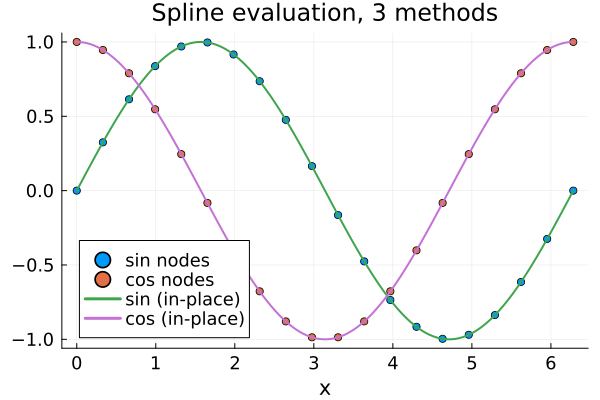

In [6]:

# ----------------------------- 1. setup -----------------------------
xs  = range(0, 2π; length=20) |> collect
fs  = sin.(xs)
fc  = cos.(xs)
spline = JPEC.SplinesMod.spline_setup(xs, hcat(fs, fc), 2)

xs_fine = range(0, 2π; length=1_000) |> collect
n_fine  = length(xs_fine)

println("---- Performance comparison ----")

# ------------------------- 2-A. external vector -------------------------
function run_alloc_eval(spl, xs)
    JPEC.SplinesMod.spline_eval(spl, xs)   # Assign matrices at once
end
println("\nallocating (`spline_eval` VEC→MAT):")
@btime run_alloc_eval($spline, $xs_fine);

# ------------------------- 2-B. in-place ---------------------------
function run_inplace_eval(spl, xs, out)
    @inbounds for (i, x) in enumerate(xs)
        JPEC.SplinesMod.spline_eval!(spl, x, 0)     # result is spl.f
        @views out[i, :] .= spl.f                   
    end
    return out
end
out_inplace = Matrix{Float64}(undef, n_fine, spline.nqty)
println("\nin-place (`spline_eval!` loop):")
@btime run_inplace_eval($spline, $xs_fine, $out_inplace);

# ------------------------- 2-C. external(one-by-one) ---------------
function run_external_scalar(spl, xs, out)
    @inbounds for (i, x) in enumerate(xs)
        out[i, :] .= JPEC.SplinesMod.spline_eval(spl, x)
    end
    return out
end
out_scalar = Matrix{Float64}(undef, n_fine, spline.nqty)
println("\nexternal scalar (`spline_eval` loop):")
@btime run_external_scalar($spline, $xs_fine, $out_scalar);

# ------------------------- 3. Validation & Visualization ------------------------
@assert isapprox(out_inplace, out_scalar) 
@assert isapprox(out_inplace, run_alloc_eval(spline, xs_fine))


default(titlefont = font(16), guidefont = font(14),
        tickfont = font(12),  legendfont = font(12))  

p = plot(xs,  [fs fc]; seriestype = :scatter,
         label = ["sin nodes" "cos nodes"],
         title = "Spline evaluation, 3 methods",
         xlabel = "x")
plot!(p, xs_fine, out_inplace,
      label = ["sin (in-place)" "cos (in-place)"], lw = 2)
display(p)
